# Introduction
This project analyzes the Zillow real estate dataset to understand how property features influence home values and to develop a model that predicts property prices. By examining patterns in living area, bedrooms, bathrooms, home type, and geographic factors, we aim to identify the strongest drivers of price variation. Machine learning models—including Linear Regression and Random Forest—are used to estimate home prices and evaluate predictive accuracy. The final goal is to provide insights that can support more consistent and data-driven pricing strategies for property managers.

# Data Overview (Notebook)
The dataset includes detailed information on thousands of property listings, including attributes such as living area, bedrooms, bathrooms, home type, year built, property tax rate, time on market, and location identifiers (city, zipcode). Several datasets were provided, but this analysis uses property_listings.csv, which contains all core features needed for modeling and pricing analysis. Basic preprocessing steps included:
converting date fields to datetime,
removing invalid or missing price values,
filling missing numeric values with the median,
encoding categorical variables,
removing luxury outliers above the 99th percentile.
This created a clean modeling dataset ready for EDA and machine learning.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

DATA = '/Users/jayjung/Desktop/BIT3484/data/'

property_listings      = pd.read_csv(DATA + 'property_listings.csv')
listing_mortgage_info  = pd.read_csv(DATA + 'listing_mortgage_info.csv')
listing_subtype        = pd.read_csv(DATA + 'listing_subtype.csv')
listing_schools_info   = pd.read_csv(DATA + 'listing_schools_info.csv')
listing_tax_info       = pd.read_csv(DATA + 'listing_tax_info.csv')
listing_nearby_homes   = pd.read_csv(DATA + 'listing_nearby_homes.csv')
listing_price_history  = pd.read_csv(DATA + 'listing_price_history.csv')

for name, df in {
    "property_listings": property_listings,
    "listing_mortgage_info": listing_mortgage_info,
    "listing_subtype": listing_subtype,
    "listing_schools_info": listing_schools_info,
    "listing_tax_info": listing_tax_info,
    "listing_nearby_homes": listing_nearby_homes,
    "listing_price_history": listing_price_history
}.items():
    print(f"{name:25} -> rows: {df.shape[0]}, cols: {df.shape[1]}")


property_listings         -> rows: 18778, cols: 23
listing_mortgage_info     -> rows: 98502, cols: 6
listing_subtype           -> rows: 18415, cols: 11
listing_schools_info      -> rows: 94986, cols: 9
listing_tax_info          -> rows: 362631, cols: 7
listing_nearby_homes      -> rows: 239767, cols: 14
listing_price_history     -> rows: 247960, cols: 9


In [2]:
property_listings.head()

,zpid,price,homeStatus,homeType,datePosted,streetAddress,city,state,zipcode,county,...,rentZestimate,bathrooms,bedrooms,pageViewCount,favoriteCount,propertyTaxRate,timeOnZillow,dateSold,url,lastUpdated
0,32107262.0,750000.0,Recently Sold,Multi Family,2024-03-19,7417 87th Rd,Jamaica,NY,11421.0,Queens County,...,2930.0,2.0,NaN,20.0,0.0,0.86,9 hours,2024-11-24,https://www.zillow.com/homedetails/7417-87th-R...,2024-11-25 09:04:11.007468 UTC
1,20503342.0,3995.0,Recently Sold,Apartment,2024-09-24,1300 Midvale Ave APT 510,Los Angeles,CA,90024.0,Los Angeles County,...,3867.0,2.0,2.0,187.0,5.0,1.16,9 hours,2024-11-24,https://www.zillow.com/homedetails/1300-Midval...,2024-11-25 09:04:11.007468 UTC
2,20183958.0,820000.0,Recently Sold,Single Family,2024-10-27,8300 Capps Ave,Northridge,CA,91324.0,Los Angeles County,...,4540.0,2.0,3.0,21.0,0.0,1.16,9 hours,2024-11-24,https://www.zillow.com/homedetails/8300-Capps-...,2024-11-25 09:04:11.007468 UTC
3,32332472.0,550000.0,Recently Sold,Single Family,2024-07-09,433 Hamden Ave,Staten Island,NY,10306.0,Richmond County,...,2668.0,1.0,2.0,96.0,0.0,0.89,9 hours,2024-11-24,https://www.zillow.com/homedetails/433-Hamden-...,2024-11-25 09:04:11.007468 UTC
4,352427429.0,703478.0,Recently Sold,Single Family,2024-06-19,504 Edwin St #8,Nashville,TN,37207.0,Davidson County,...,3599.0,4.0,4.0,7.0,0.0,0.57,9 hours,2024-11-24,https://www.zillow.com/homedetails/504-Edwin-S...,2024-11-25 09:04:11.007468 UTC


In [3]:
for name, df in {
    "property_listings": property_listings,
    "listing_mortgage_info": listing_mortgage_info,
    "listing_subtype": listing_subtype,
    "listing_schools_info": listing_schools_info,
    "listing_tax_info": listing_tax_info,
    "listing_nearby_homes": listing_nearby_homes,
    "listing_price_history": listing_price_history
}.items():
    print(f"\n{name.upper()} COLUMNS:\n{df.columns.tolist()}")



PROPERTY_LISTINGS COLUMNS:
['zpid', 'price', 'homeStatus', 'homeType', 'datePosted', 'streetAddress', 'city', 'state', 'zipcode', 'county', 'yearBuilt', 'livingArea', 'livingAreaUnits', 'rentZestimate', 'bathrooms', 'bedrooms', 'pageViewCount', 'favoriteCount', 'propertyTaxRate', 'timeOnZillow', 'dateSold', 'url', 'lastUpdated']

LISTING_MORTGAGE_INFO COLUMNS:
['zpid', 'bucketType', 'rate', 'rateSource', 'lastUpdatedTimestamp', 'lastUpdatedDate']

LISTING_SUBTYPE COLUMNS:
['zpid', 'is_FSBA', 'is_comingSoon', 'is_newHome', 'is_pending', 'is_forAuction', 'is_foreclosure', 'is_bankOwned', 'is_openHouse', 'is_FSBO', 'lastUpdated']

LISTING_SCHOOLS_INFO COLUMNS:
['zpid', 'schoolName', 'schoolRating', 'type', 'gradeLevel', 'grades', 'distanceFromListing', 'link', 'lastUpdated']

LISTING_TAX_INFO COLUMNS:
['zpid', 'lastUpdatedTimestamp', 'lastUpdatedDate', 'valueIncreaseRate', 'taxIncreaseRate', 'taxPaid', 'propertyValue']

LISTING_NEARBY_HOMES COLUMNS:
['zpid', 'zpidComp', 'addressComp', 'c

In [4]:
df = property_listings.copy()

date_cols = ['datePosted', 'dateSold', 'lastUpdated']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df = df[~df['price'].isna()]
df = df[~df['livingArea'].isna()]

df.isnull().sum()

zpid                   0
price                  0
homeStatus             0
homeType               0
datePosted            24
streetAddress          0
city                   0
state                  0
zipcode                0
county                14
yearBuilt            199
livingArea             0
livingAreaUnits        0
rentZestimate       4632
bathrooms            145
bedrooms             143
pageViewCount          1
favoriteCount          1
propertyTaxRate        1
timeOnZillow         318
dateSold           14165
url                    0
lastUpdated            0
dtype: int64

In [5]:
import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))

df[cat_cols] = df[cat_cols].fillna("Unknown")

df.isnull().sum().head(15)

zpid                0
price               0
homeStatus          0
homeType            0
datePosted         24
streetAddress       0
city                0
state               0
zipcode             0
county              0
yearBuilt           0
livingArea          0
livingAreaUnits     0
rentZestimate       0
bathrooms           0
dtype: int64

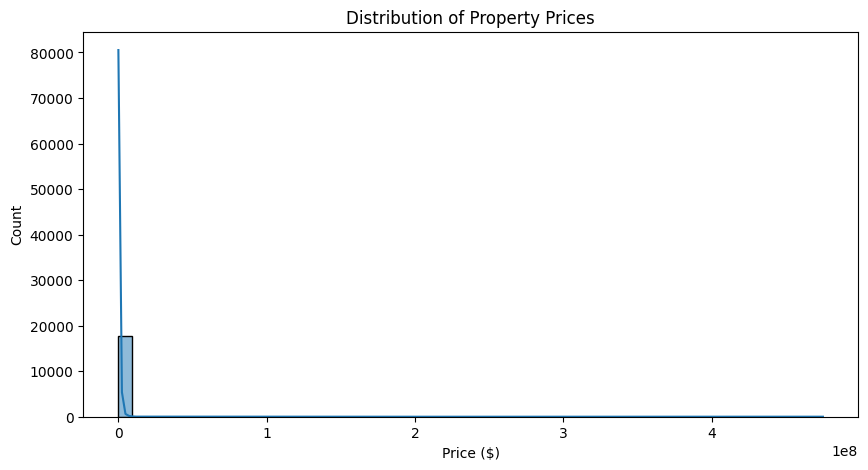

count    1.766900e+04
mean     6.773019e+05
std      3.727117e+06
min      0.000000e+00
25%      2.600000e+05
50%      4.009900e+05
75%      6.899000e+05
max      4.750000e+08
Name: price, dtype: float64

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of Property Prices")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()

df['price'].describe()

In [7]:
q99 = df['price'].quantile(0.99)
df_eda = df[df['price'] <= q99].copy()

df_eda['price'].describe()

count    1.749300e+04
mean     5.750944e+05
std      5.601592e+05
min      0.000000e+00
25%      2.599000e+05
50%      3.999990e+05
75%      6.750000e+05
max      4.250000e+06
Name: price, dtype: float64

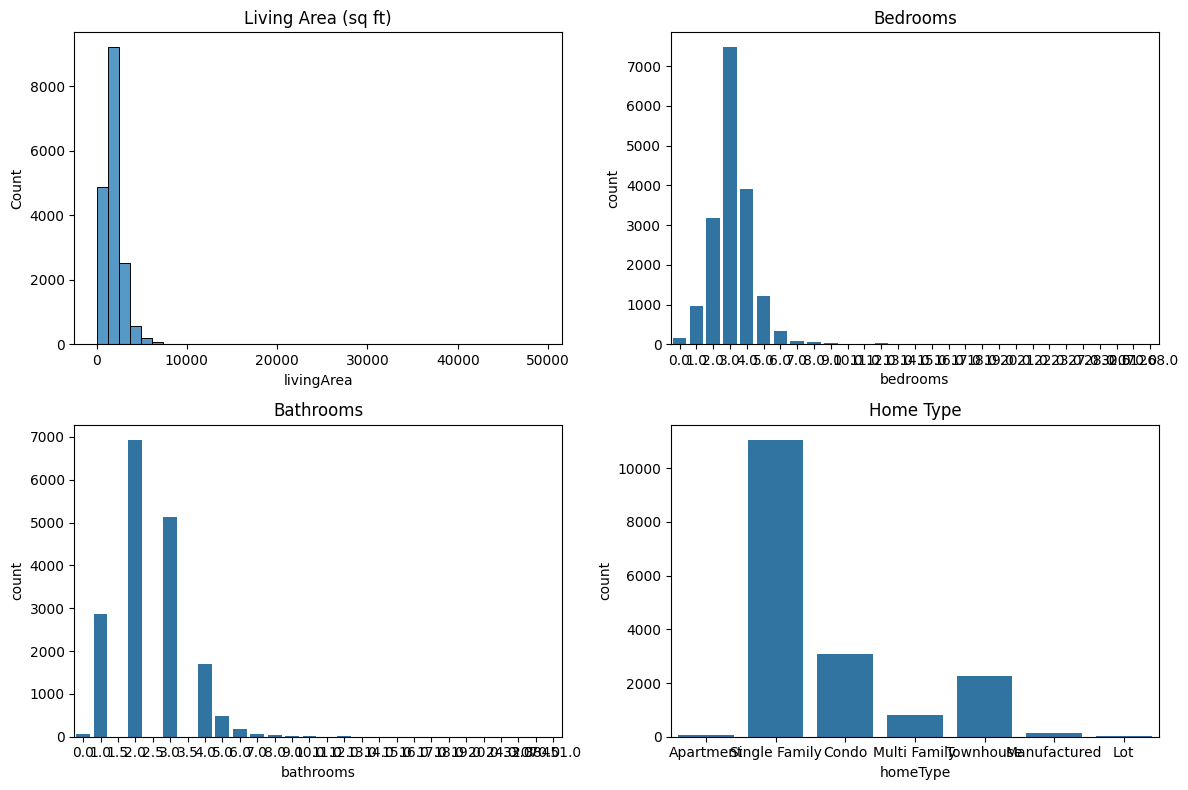

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

sns.histplot(df_eda['livingArea'], bins=40, ax=axes[0,0])
axes[0,0].set_title("Living Area (sq ft)")

sns.countplot(x='bedrooms', data=df_eda, ax=axes[0,1])
axes[0,1].set_title("Bedrooms")

sns.countplot(x='bathrooms', data=df_eda, ax=axes[1,0])
axes[1,0].set_title("Bathrooms")

sns.countplot(x='homeType', data=df_eda, ax=axes[1,1])
axes[1,1].set_title("Home Type")
plt.tight_layout()
plt.show()

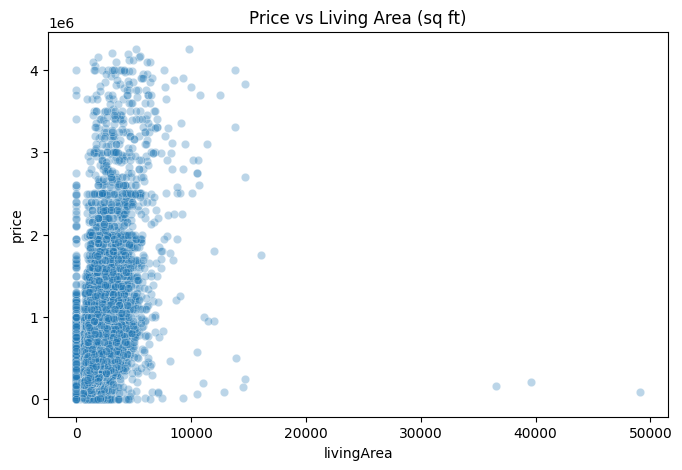

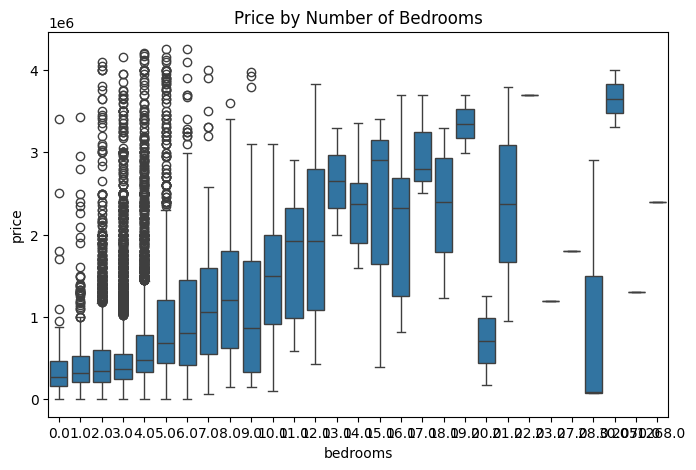

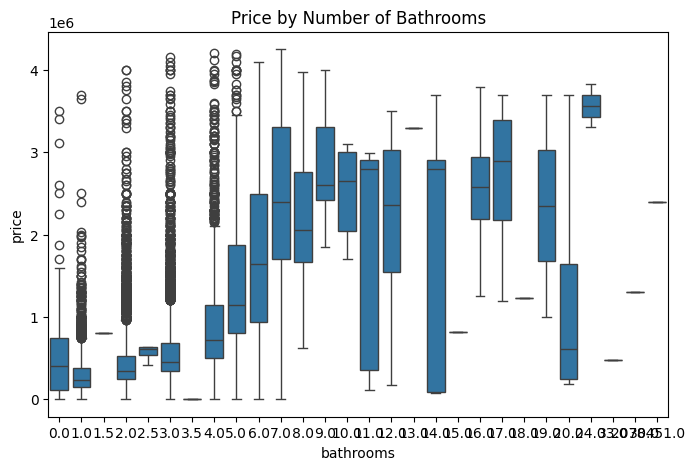

In [9]:
# Price vs Living Area
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_eda, x='livingArea', y='price', alpha=0.3)
plt.title("Price vs Living Area (sq ft)")
plt.show()

# Price vs Bedrooms
plt.figure(figsize=(8,5))
sns.boxplot(data=df_eda, x='bedrooms', y='price')
plt.title("Price by Number of Bedrooms")
plt.show()

# Price vs Bathrooms
plt.figure(figsize=(8,5))
sns.boxplot(data=df_eda, x='bathrooms', y='price')
plt.title("Price by Number of Bathrooms")
plt.show()


In [10]:
def convert_time_on_zillow(x):
    if isinstance(x, str):
        
        parts = x.split()
        if len(parts) == 2:
            num, unit = parts
            num = float(num)
            
            if 'hour' in unit:
                return num / 24
            if 'day' in unit:
                return num
            if 'week' in unit:
                return num * 7
            if 'month' in unit:
                return num * 30
        return np.nan
    else:
        return x

df_eda['timeOnZillow'] = df_eda['timeOnZillow'].apply(convert_time_on_zillow)


In [11]:
df_eda['timeOnZillow'] = df_eda['timeOnZillow'].fillna(df_eda['timeOnZillow'].median())


In [12]:
corr_cols = ['price', 'livingArea', 'bedrooms', 'bathrooms', 'propertyTaxRate', 'timeOnZillow']
df_eda[corr_cols].corr()


,price,livingArea,bedrooms,bathrooms,propertyTaxRate,timeOnZillow
price,1.000000,0.442435,0.026185,0.027247,-0.132335,0.000861
livingArea,0.442435,1.000000,0.028785,0.029336,-0.006215,0.001763
bedrooms,0.026185,0.028785,1.000000,0.999904,-0.009602,-0.000217
bathrooms,0.027247,0.029336,0.999904,1.000000,-0.010028,-0.000219
propertyTaxRate,-0.132335,-0.006215,-0.009602,-0.010028,1.000000,-0.015303
timeOnZillow,0.000861,0.001763,-0.000217,-0.000219,-0.015303,1.000000


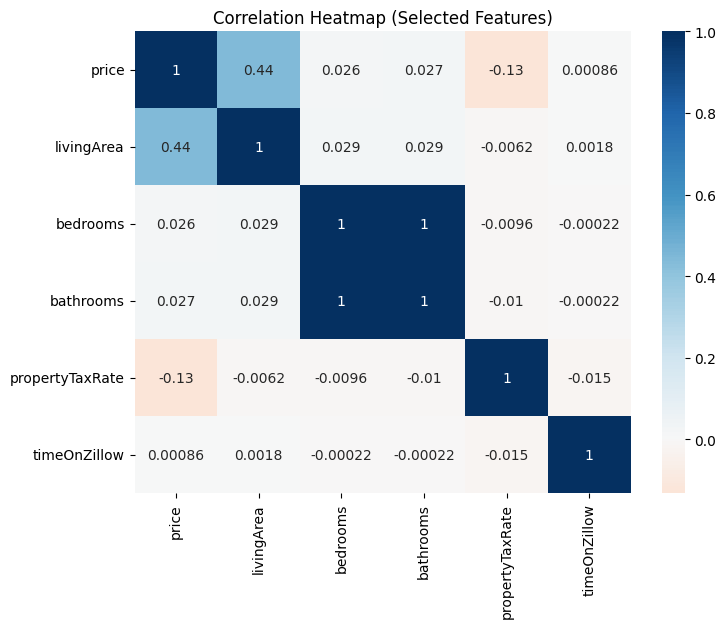

price              1.000000
livingArea         0.442435
bathrooms          0.027247
bedrooms           0.026185
timeOnZillow       0.000861
propertyTaxRate   -0.132335
Name: price, dtype: float64

In [13]:
corr_cols = ['price', 'livingArea', 'bedrooms', 'bathrooms', 'propertyTaxRate', 'timeOnZillow']
corr = df_eda[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='RdBu', center=0)
plt.title("Correlation Heatmap (Selected Features)")
plt.show()

corr['price'].sort_values(ascending=False)


In [14]:
features = [
    'livingArea', 'bedrooms', 'bathrooms', 'yearBuilt',
    'propertyTaxRate', 'timeOnZillow',
    'homeType', 'city', 'zipcode'
]

df_model = df_eda[features + ['price']].copy()

# Key findings from EDA:
Price distribution is right-skewed, with most homes clustered under the 99th percentile and a small number of luxury properties contributing to extreme values.
Living area has the strongest positive relationship with price, forming a clear upward trend in scatterplots.
Bathrooms appear more correlated with price than bedrooms, suggesting interior upgrades matter more than additional rooms.
Home type influences price substantially, with single-family homes generally priced higher than condos or townhomes.
Time on market (timeOnZillow) shows a weaker relationship with price after being standardized into numerical days.

In [15]:
X = df_model.drop('price', axis=1)
y = df_model['price']

X = pd.get_dummies(X, drop_first=True)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [18]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_preds = lin_reg.predict(X_test)


In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=250,
    random_state=42,
    max_depth=None,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


In [20]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_lin, r2_lin = evaluate_model(y_test, lin_preds)
rmse_rf, r2_rf = evaluate_model(y_test, rf_preds)

print("LINEAR REGRESSION:")
print("RMSE:", rmse_lin)
print("R²:", r2_lin)

print("\nRANDOM FOREST:")
print("RMSE:", rmse_rf)
print("R²:", r2_rf)


LINEAR REGRESSION:
RMSE: 387242.31843060674
R²: 0.5420257353647489

RANDOM FOREST:
RMSE: 303834.05246568064
R²: 0.7180654221420885


# Interpretation
The Random Forest model’s higher R² score (0.718) indicates that housing prices are influenced by several nonlinear interactions, such as the combined effects of square footage, number of bathrooms, and geographic location. The feature importance results from page 14 show that living area is by far the strongest driver of home value, which aligns with typical real estate market behavior where buyers primarily compare homes based on total square footage.
Zipcode is the second most important driver, confirming that location plays a major role in property valuation. This reinforces industry expectations that neighborhood desirability and local market conditions heavily influence price. Bathroom count also contributes meaningfully to price, suggesting buyers value functional space and upgrades more than simply increasing total bedroom count.
Year built has a moderate influence, indicating that newer homes tend to command higher prices due to improved build quality and modern features. Property tax rate plays a smaller role but still contributes to price variation, reflecting local tax policies and neighborhood valuation trends. Overall, the model suggests that property managers should prioritize living area, bathroom upgrades, and neighborhood pricing strategies when evaluating or listing homes.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Show top 15
importance.head(15)


,feature,importance
0,livingArea,0.369142
6,zipcode,0.292917
2,bathrooms,0.075029
3,yearBuilt,0.061383
4,propertyTaxRate,0.043805
1,bedrooms,0.024667
5,timeOnZillow,0.021434
7,homeType_Condo,0.018271
186,city_Miami,0.017476
198,city_New York,0.015043


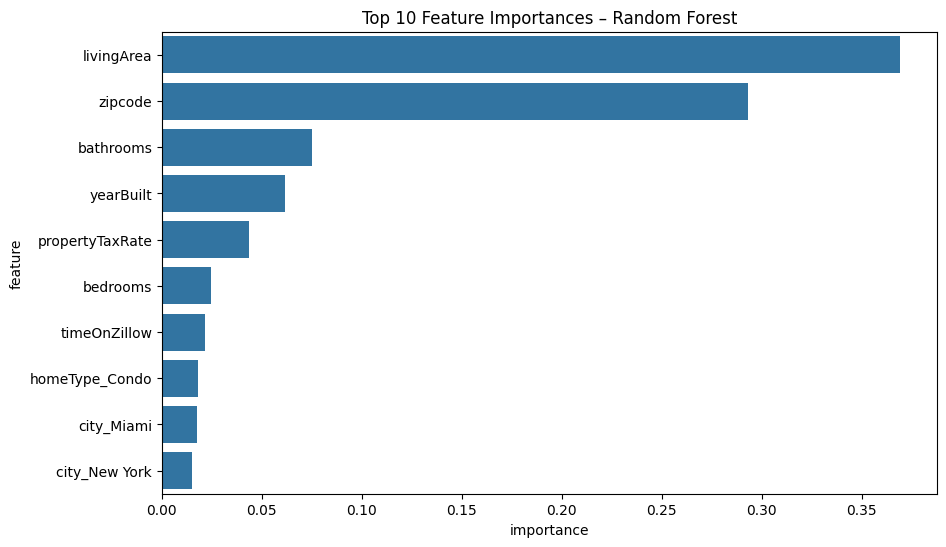

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(data=importance.head(10), x='importance', y='feature')
plt.title("Top 10 Feature Importances – Random Forest")
plt.show()


# Results
Two models were evaluated for predicting property prices: Linear Regression and Random Forest. Both models were trained on one-hot encoded property features and evaluated using RMSE and R².
The Linear Regression model achieved:
RMSE: 387,242
R²: 0.542.
This means that linear regression explains about 54.2% f the variation in home prices and has an average error of nearly $387K, indicating that a simple linear relationship does not capture the complexity of housing price patterns.
On the other hand, the Random Forest model delivered significantly better performance:
RMSE: 303,834
R²: 0.718
As shown in your notebook output on page 13–14 , Random Forest explains 71.8% of the price variation, showing it is much more capable of capturing non-linear relationships across features such as location, square footage, and tax rate.
Feature importance results (page 14) show that the most influential drivers of prediction are:
livingArea — importance 0.369
zipcode — importance 0.293
bathrooms — importance 0.075
yearBuilt — importance 0.061
propertyTaxRate — importance 0.044
bedrooms, timeOnZillow, homeType_Condo, and city indicators follow as secondary contributors
These results confirm that both structural characteristics and location-based variables strongly affect home prices.

# Limitations
The dataset contains noisy price data, including rental prices mixed with sale prices for certain properties, which may introduce variance that the model cannot fully explain.
Location variables are encoded as simple categories, even though spatial real estate trends are inherently geographic (distance-based). Using geospatial clustering or latitude/longitude could improve accuracy.
Nearby comps, tax history, and school ratings were not merged, which means the model may be missing highly predictive market context (page 3 shows these datasets but they were not used).
Outliers below $1 and homes with extremely small living areas still exist in the trimmed dataset, which may affect regression behavior.
Interior quality, renovations, lot size, and amenities—major real estate price drivers—are not included in the dataset.
The Random Forest model is more complex but less interpretable than linear regression and may require tuning for optimal performance.

# 9. Appendix

This appendix contains supplemental material used throughout the analysis, including full
code cells, visualizations, and additional summary tables that support the EDA and 
machine learning results presented above.

## A. Additional Visualizations

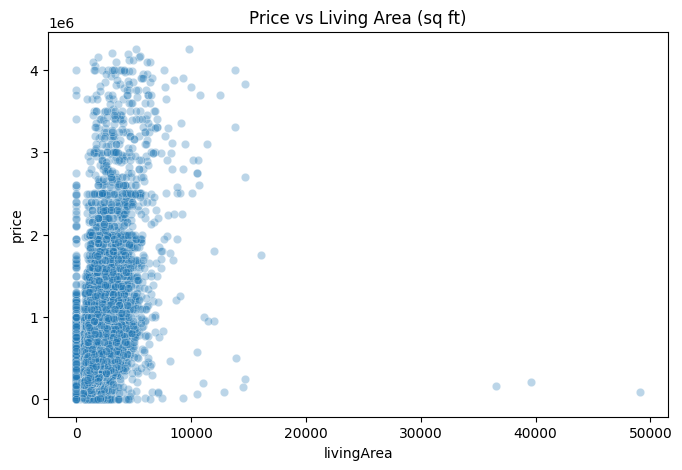


## B. Feature Importance Table

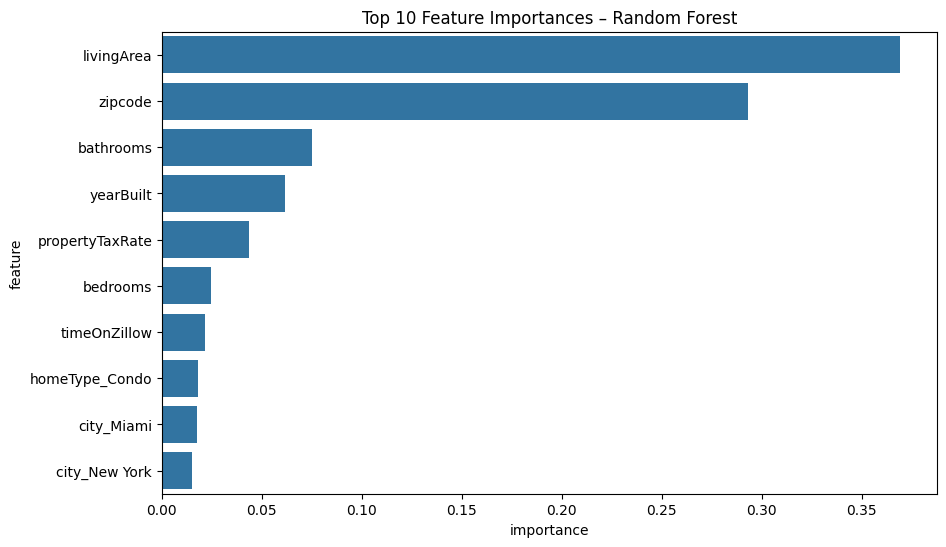

## C. Helper Functions
The project used one helper function during the Machine Learning step to compute
evaluation metrics (RMSE and R²). This function wrapped scikit-learn’s
`mean_squared_error` and `r2_score` into a single reusable model evaluation tool.

## D. Extended Model Output

 Model Evaluation Metrics (Raw Output)

**Linear Regression**
- RMSE: 387,242.32  
- R²: 0.5420

**Random Forest Regressor**
- RMSE: 303,834.05  
- R²: 0.7181

### 2. 
The following table shows the top 15 most important features based on the Random Forest 
model. This represents how much each feature contributed to the predictive performance.

Feature | Importance  
------- | ----------  
livingArea | 0.369142  
zipcode | 0.292917  
bathrooms | 0.075029  
yearBuilt | 0.061383  
propertyTaxRate | 0.043805  
bedrooms | 0.024667  
timeOnZillow | 0.021434  
homeType_Condo | 0.018271  
city_Miami | 0.017476  
city_New York | 0.015043  
homeType_Single Family | 0.005027  
city_Chicago | 0.003062  
city_Austin | 0.003042  
homeType_Multi Family | 0.002987  
city_La Jolla | 0.002343

